<a href="https://colab.research.google.com/github/shreyas269/programming/blob/master/machine_learning/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from torchvision import datasets, transforms, models

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Load Dataset
!git clone https://github.com/jaddoescad/ants_and_bees.git

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [0]:
# Hyperparameters
std = np.array((0.5, 0.5, 0.5))
mean = np.array((0.5, 0.5, 0.5))
epochs = 10
training_batch_size = 20
validation_batch_size = 20
lrn_rate = 0.0001

In [0]:
# Declaring and assigning Hyperparameters in a namedtuple
HParams = namedtuple('HPS', 'std, mean, epochs, training_batch_size, validation_batch_size, lrn_rate')
hps = HParams(std=std, mean=mean, epochs=epochs, training_batch_size=training_batch_size, validation_batch_size=validation_batch_size, lrn_rate=lrn_rate)

In [0]:
# In PyTorch, images are represented as [channels, height, width]
# For a 256x256 coloured image, [channels, height, width] = [3, 256, 256]
# For grayscale, channels=1

# "transforms" are common image transformations
# tansforms.Compose chains together transformations
# ToTensor() converts numpy array (PIL image) to FloatTensor in range [0.0, 1.0]. Transforms numpy [H, W, C] to Tensor [C, H, W]

transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Three channels for RGB
                               ])


transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# This maps image FloatTensor values from [0.0, 1.0] to [-1.0, 1.0]

In [7]:
training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train)
training_dataset

Dataset ImageFolder
    Number of datapoints: 244
    Root location: ants_and_bees/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=(0, 0), scale=(0.8, 1.2), shear=(-10, 10))
               ColorJitter(brightness=[0, 2], contrast=[0, 2], saturation=[0, 2], hue=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [8]:
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)
validation_dataset

Dataset ImageFolder
    Number of datapoints: 153
    Root location: ants_and_bees/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [0]:
# tensor.detach() creates a tensor that shares storage with tensor that does not require grad, i.e. detaches output from computation graph.

# Converts tensor image to numpy
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy() # Is now [C, H, W]
  image = image.transpose(1, 2, 0) # Is now [H, W, C]

  # Denormalize the image
  # 1. Convert [-1, 1] to [0, 1]

  print(image.shape)
  
  image = image * std + mean
  image.clip(0, 1) # To ensure image value is between [0, 1]

  return image

In [0]:
classes = ('ant', 'bee')

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


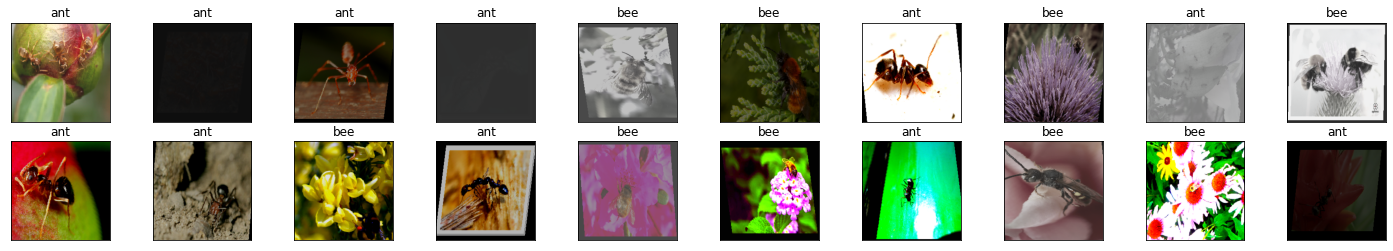

In [11]:
# Provides an iterable over the given dataset as per the sampler provided (optional). Set shuffle=True for default random sampler.
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=hps.training_batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=hps.validation_batch_size, shuffle=False)

data_iter = iter(training_loader)
images, labels = data_iter.next() # Grabs first batch of data

images = images.to(device)
labels = labels.to(device)

# show sampled training images
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
# NN Class model
model = models.alexnet(pretrained=True)

In [13]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
for params in model.features.parameters():
  params.required_grad = False

In [0]:
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))

model.classifier[6] = last_layer

In [16]:
model = model.to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
# Define Loss
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD, Adam etc)
optimizer = torch.optim.Adam(model.parameters(), lr=hps.lrn_rate)

In [0]:
def pred_image_loader(loader):
  for inputs, labels in loader:
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_loss+=loss.item()

    _, preds = torch.max(outputs, 1) 
    correct_preds = (preds == labels.data)
    running_corrects += torch.sum(correct_preds)
  
  return running_loss, running_corrects

In [0]:
def run_image_loader(loader, mode): # mode is either 'train' or 'eval'
  running_loss = 0.0  # Accumulates loss from all training examples in the batch
  running_corrects = 0.0 # Accumulates accuracy from all training examples in the batch

  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    training = False
    if mode=='train':
      training=True
    elif mode not in ['train', 'eval']:
      print("Invalid mode: ", mode, " used")
      print("Using default 'eval' mode")

    if(training==True):
      # Zero the gradients to avoid accumulation
      optimizer.zero_grad()

      # Find the gradient values
      loss.backward()

      # Optimize the parameter values by subtracting lr*gradient
      optimizer.step()

    running_loss+=loss.item()

    _, preds = torch.max(outputs, 1) 
    correct_preds = (preds == labels.data)
    running_corrects += torch.sum(correct_preds)
  
  return running_loss, running_corrects

In [20]:
running_loss_history = [] # List containing training Loss values of a batch in every epoch
running_accuracy_history = [] # List containing training accuracy values of a batch in every epoch

val_running_loss_history = [] # List containing validation Loss values of a batch in every epoch
val_running_accuracy_history = [] # List containing validation accuracy values of a batch in every epoch

for e in range(hps.epochs):
  running_loss, running_corrects = run_image_loader(training_loader, 'train')

  with torch.no_grad(): # No need for gradients while predicting on validation set
      val_running_loss, val_running_corrects = run_image_loader(validation_loader, 'eval')

  epoch_loss = running_loss/len(training_loader.dataset) # epoch_loss is average loss of input example
  epoch_accuracy = running_corrects.float()/len(training_loader.dataset) # epoch_accuracy is accuracy of model over the partially trained model at a particular epoch

  running_loss_history.append(epoch_loss)
  running_accuracy_history.append(epoch_accuracy)

  val_epoch_loss = val_running_loss/len(validation_loader.dataset) # epoch_loss is average loss of input example
  val_epoch_accuracy = val_running_corrects.float()/len(validation_loader.dataset) # epoch_accuracy is accuracy of model over the partially trained model at a particular epoch

  val_running_loss_history.append(val_epoch_loss)
  val_running_accuracy_history.append(val_epoch_accuracy)

  print("epoch: {}, training loss: {:.4f}, training accuracy: {:.4f}, validation loss: {:.4f}, validation accuracy: {:.4f}".format(e+1, epoch_loss, epoch_accuracy.item(), val_epoch_loss, val_epoch_accuracy.item()))

epoch: 1, training loss: 0.0387, training accuracy: 0.5615, validation loss: 0.0279, validation accuracy: 0.7059
epoch: 2, training loss: 0.0380, training accuracy: 0.5656, validation loss: 0.0237, validation accuracy: 0.8301
epoch: 3, training loss: 0.0280, training accuracy: 0.7172, validation loss: 0.0176, validation accuracy: 0.8366
epoch: 4, training loss: 0.0230, training accuracy: 0.7582, validation loss: 0.0211, validation accuracy: 0.8627
epoch: 5, training loss: 0.0229, training accuracy: 0.7664, validation loss: 0.0184, validation accuracy: 0.8562
epoch: 6, training loss: 0.0200, training accuracy: 0.7869, validation loss: 0.0177, validation accuracy: 0.8758
epoch: 7, training loss: 0.0201, training accuracy: 0.8115, validation loss: 0.0183, validation accuracy: 0.8562
epoch: 8, training loss: 0.0173, training accuracy: 0.8238, validation loss: 0.0197, validation accuracy: 0.8627
epoch: 9, training loss: 0.0140, training accuracy: 0.8525, validation loss: 0.0199, validation 

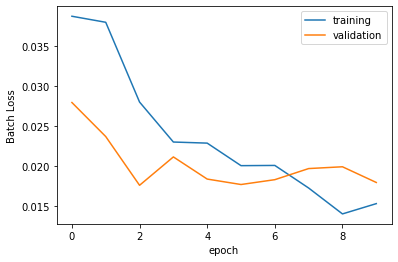

In [21]:
plt.plot(running_loss_history, label='training')
plt.plot(val_running_loss_history, label='validation')
plt.ylabel('Batch Loss')
plt.xlabel('epoch')
plt.legend()

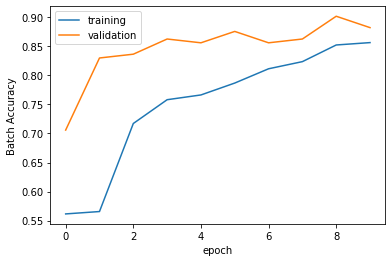

In [22]:
plt.plot(running_accuracy_history, label='training')
plt.plot(val_running_accuracy_history, label='validation')
plt.ylabel('Batch Accuracy')
plt.xlabel('epoch')
plt.legend()